In [184]:
import sys, os, subprocess, json, pickle, uproot, math
import numpy as np
import pandas as pd
import awkward as ak
from datetime import datetime
from tqdm import tqdm
from xgboost import XGBRegressor, XGBClassifier, plot_importance
import mplhep as hep

from matplotlib import pyplot as plt
import plotly.graph_objects as go

In [185]:
def get_arrays(tree, branch_list):
    _dict = {}
    for _br in branch_list:
        _dict[_br] = getattr(tree[_br].arrays(), _br)
    return pd.DataFrame.from_dict(_dict)

def get_input_features(df, train_list, cuts=''):
    if cuts=='': return df[train_list].to_numpy()
    _df = df[df.eval(cuts)]
    return _df[train_list].to_numpy()

def plot_training_history(model, category, fold, metric):    
    results = model.evals_result()
    epochs = len(results['validation_0'][metric])
    x_axis = range(0, epochs)
    fig, ax = plt.subplots(figsize=(6.6,4.4))
    ax.plot(x_axis, results['validation_0'][metric], label='Train')
    ax.plot(x_axis, results['validation_1'][metric], label='Test')
    ax.legend(fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    plt.title('{} (iFold={})'.format(category, fold), fontsize=16)
    plt.show()
    fig.savefig(out_dir+"/AUC_plot_"+category+"fold_"+str(fold)+".png")

def load_pkl(fname):
    with open(fname, 'rb') as f:
        obj = pickle.load(f)
    return obj

def get_parameters(json_file, cat):
    """Get parameters for XGBoost"""
    parameters = json_file["xgb_parameters_"+cat]
    param = {}
    for entry in parameters:
        key = list(entry.keys())[0]
        value = entry[key]
        param[key] = value
    return param

In [186]:
# Open config File
config = "config.json"
with open(config, 'r') as file:
    json_file_temp = json.load(file)
    
output_folder = json_file_temp['output_folder']
try:
    label = json_file_temp['label']
except KeyError:
    label = ""

In [187]:
# Create new config File
date = datetime.now().strftime("%Y%m%d-%H%M%S")
out_dir = output_folder+"/"+label+"_"+date
if not os.path.exists(out_dir):
    subprocess.call("mkdir -p %s" % out_dir, shell=True)
config_out = out_dir+"/config.json"
json_file_temp["date"] = date
with open(config_out, 'w') as file:
    json.dump(json_file_temp, file, indent=2)

In [188]:
# Open new config File
with open(config_out, 'r') as file:
    json_file = json.load(file)

categories_list = json_file["categories"]
param = []
for c in categories_list:
    param_temp = get_parameters(json_file, c)
    param.append(param_temp)

In [189]:
# load data
input_files = json_file['input_files']
training_variables = json_file['training_variables']
spectator_variables = json_file['spectator_variables']
tree_name = json_file['tree_name']
dfs = []
for file in input_files:
    print("Loading data from ", file)
    file_temp = uproot.open(file)
    df_temp = get_arrays(file_temp[tree_name], training_variables+spectator_variables)
    dfs.append(df_temp)
df = pd.concat(dfs)
df = df.reset_index(drop=True)
del dfs

Loading data from  ../Utilities_organized/ROOTFiles_mySel/AllData2022.root
Loading data from  ../Utilities_organized/ROOTFiles_mySel/AllData2023.root


In [190]:
print(df['isMC'].unique())
df['isMC'] = df['isMC'].clip(lower=0)
print(df['isMC'].unique())

[1 0 2]
[1 0 2]


In [191]:
index_branch = [json_file['index_branch']]
kFolds = json_file['number_of_splits']
try:
    weight_column = [json_file['weight_column']]
except KeyError:
    weight_column = None
X_list = []
y_list = []
weight_train_list = []
kfold_split_list = []

print(categories_list)
for cat in categories_list:
    try:
        bkg_sel = json_file[cat+"_bkg"]
    except KeyError:
        bkg_sel = ""
    try:
        sig_sel = json_file[cat+"_sig"]
    except KeyError:
        sig_sel = ""
    X_bkg_temp = get_input_features(df, training_variables, bkg_sel)
    X_sig_temp = get_input_features(df, training_variables, sig_sel)
    
    y_bkg_temp = np.zeros(len(X_bkg_temp))
    y_sig_temp = np.ones(len(X_sig_temp))
    
    bkg_eventNumber = get_input_features(df, index_branch, bkg_sel)
    sig_eventNumber = get_input_features(df, index_branch, sig_sel)

    if weight_column is not None:
        W_bkg_temp = get_input_features(df, weight_column, bkg_sel)
        W_sig_temp = get_input_features(df, weight_column, sig_sel)
        
        weight_train_list.append(np.concatenate((W_bkg_temp, W_sig_temp)))

    X_list.append(np.concatenate((X_bkg_temp, X_sig_temp)))
    y_list.append(np.concatenate((y_bkg_temp, y_sig_temp)))
    kfold_split_list.append(np.concatenate((bkg_eventNumber % kFolds, sig_eventNumber % kFolds)))


['Cat']


In [192]:
xgbcvclassifiers = {cat: [] for cat in categories_list}
print(xgbcvclassifiers)

{'Cat': []}


In [193]:
# fit models 
number_of_training = kFolds*len(categories_list)
with tqdm(total=number_of_training, desc="Training... ", bar_format="{desc}: {percentage:.0f}%|{bar:80}| {n}/{total} ") as progress_bar:
    for catID in range(len(categories_list)):
        for ifold in range(kFolds):
            X_train = X_list[catID][kfold_split_list[catID].flatten()!=ifold,:]
            Y_train = y_list[catID][kfold_split_list[catID].flatten()!=ifold]
            if weight_column is not None: 
                weights_train = weight_train_list[catID][kfold_split_list[catID].flatten()!=ifold]
            
            X_test = X_list[catID][kfold_split_list[catID].flatten()==ifold,:]
            Y_test = y_list[catID][kfold_split_list[catID].flatten()==ifold]
            
            model = XGBRegressor(**param[catID])
            #model = XGBClassifier(**param[catID])

            if weight_column is not None:
                history = model.fit(X_train, Y_train,
                                    verbose               = 0,
                                    sample_weight = weights_train,
                                    eval_set=[(X_train, Y_train), (X_test, Y_test)]
                                   )
            else:
                history = model.fit(X_train, Y_train,
                                    verbose               = 0,
                                    eval_set=[(X_train, Y_train), (X_test, Y_test)]
                                   )
            
            xgbcvclassifiers[categories_list[catID]].append((model, history))
            #save model
            pickle.dump(model, open(out_dir+"/model_"+categories_list[catID]+"_fold"+str(ifold)+".pkl", "wb"))
            progress_bar.update(1)

Training... : 100%|████████████████████████████████████████████████████████████████████████████████| 5/5 


In [194]:
df["kfoldID"] = (df[index_branch] % kFolds).astype(int)
all_input_X = get_input_features(df, training_variables, '')
try:
    category_branch = json_file["category_branch"]
except KeyError:
    category_branch = "NO_category_temp"

if(len(categories_list)==1 and category_branch == "NO_category_temp"):
    df[category_branch] = 0

bdt_scores = (df[category_branch]==0).to_numpy()*(0.0)
bdt_cv_scores = (df[category_branch]==0).to_numpy()*(0.0)
folds = []
for k in range(kFolds):
    folds.append((df[category_branch]==0).to_numpy()*(0.0))
    
for ic, category_ in enumerate(xgbcvclassifiers):
    for fold_ in range(kFolds):
        all_tmpscores = xgbcvclassifiers[category_][fold_][0].predict(all_input_X)
        #all_tmpscores = xgbcvclassifiers[category_][fold_][0].predict_proba(all_input_X)[:, 1]
        bdt_scores += ((df[category_branch]==(ic)).to_numpy()*all_tmpscores)/kFolds
        folds[fold_] += (df[category_branch]==(ic)).to_numpy()*all_tmpscores 
        bdt_cv_scores += ((df[category_branch]==(ic)) & (df["kfoldID"]==(fold_)) ).to_numpy()*all_tmpscores 

df['bdt'] = bdt_scores
df['bdt_cv'] = bdt_cv_scores
bdt_folds = []
for k in range(kFolds):
    branch_name_temp = f"bdt_fold{k}"
    bdt_folds.append(branch_name_temp)
    df[branch_name_temp] = folds[k]

In [195]:
df['bdt_cv_2'] = 1 - np.log2(2 -(1 - np.log2(2 -(1 - np.log2(2 -(1 - np.log2(2 - (1 - np.log2(2 - (1 - np.log2(2 - (1 - np.log2(2 - df['bdt_cv'])))))))))))))

In [196]:
fileName = out_dir+"/TrainedDataset_"+date
df.to_csv(fileName+".csv", index=False)

In [197]:
#from ROOT import RDF
#rdf = RDF.FromCSV(fileName+"_2022.csv")
#rdf = RDF.MakeCsvDataFrame(fileName+".csv")
#rdf.Snapshot("OutputTree", fileName+"_2022.root")

## Plots:

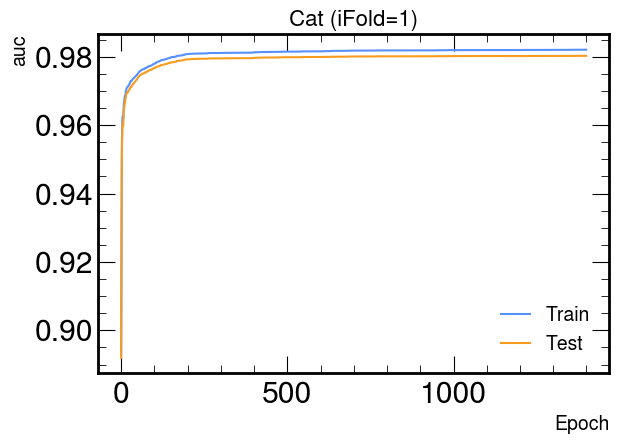

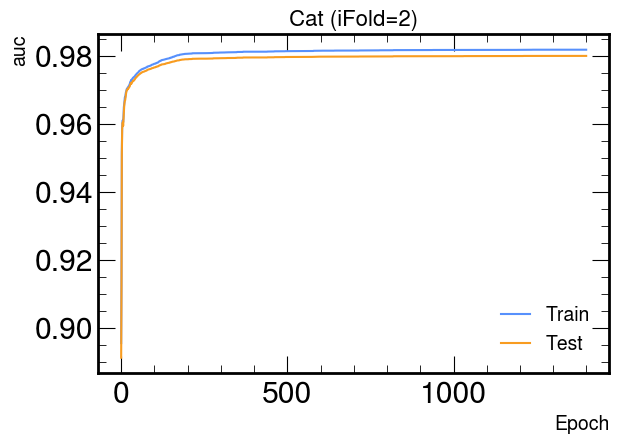

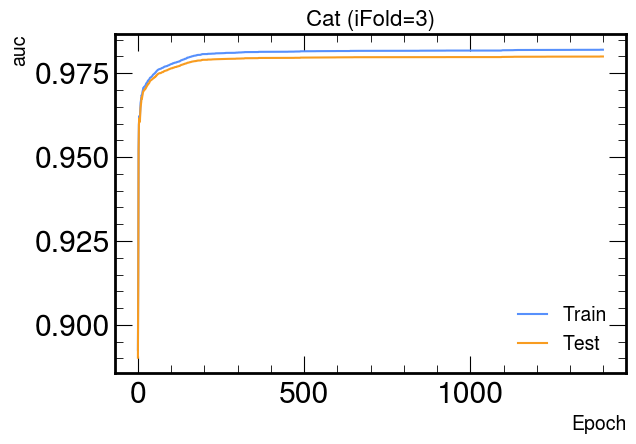

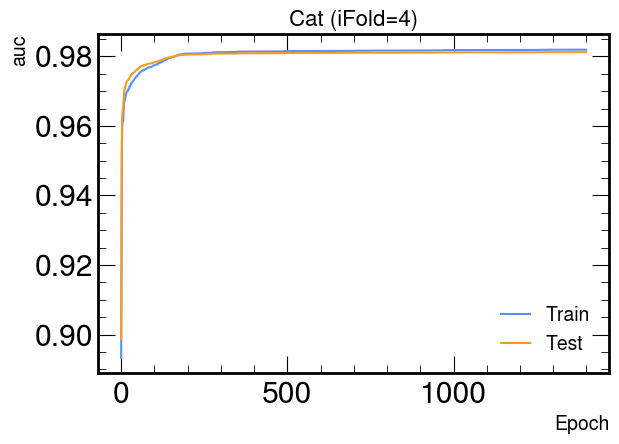

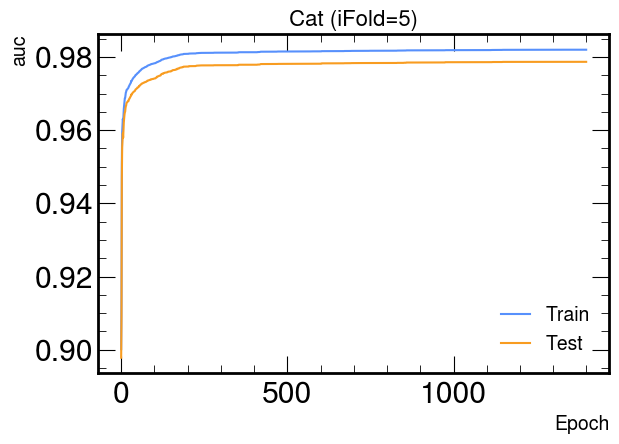

In [198]:
for category_ in xgbcvclassifiers:
    for fold_ in range(kFolds):
        plot_training_history(xgbcvclassifiers[category_][fold_][0], category_, fold_+1, param[0]["eval_metric"])

In [199]:
plt.style.use(hep.style.CMS)
signal_sel = "isMC>0"
bkg_sel = "isMC==0 & (((Quadruplet_Mass-5.366)>0.2) | ((Quadruplet_Mass-5.277)<0.2))"

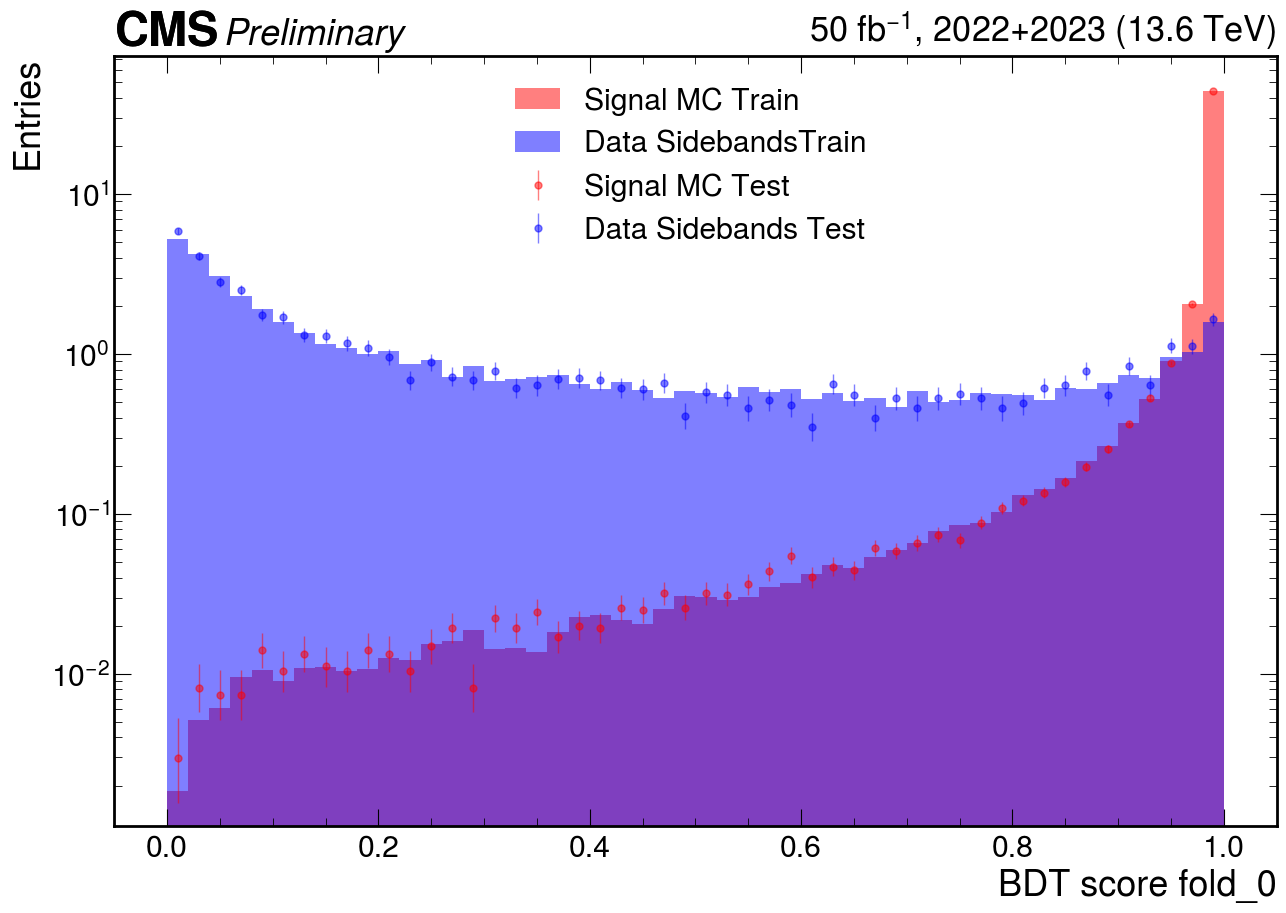

In [200]:
plt.figure(figsize=(15, 10))
plt.yscale('log')
hep.histplot(np.histogram(df[df.eval(signal_sel+" & kfoldID != 0")]["bdt_fold0"].to_numpy(), bins=50, range=(0,1)), density=True, histtype="fill", label="Signal MC Train", alpha=0.5, color='red');
hep.histplot(np.histogram(df[df.eval(signal_sel+" & kfoldID == 0")]["bdt_fold0"].to_numpy(), bins=50, range=(0,1)), density=True, histtype="errorbar", label="Signal MC Test", alpha=0.5, color='red');
hep.histplot(np.histogram(df[df.eval(bkg_sel+" & kfoldID != 0")]["bdt_fold0"].to_numpy(), bins=50, range=(0,1)), density=True, histtype="fill", label="Data SidebandsTrain ", alpha=0.5, color='blue');
hep.histplot(np.histogram(df[df.eval(bkg_sel+" & kfoldID == 0")]["bdt_fold0"].to_numpy(), bins=50, range=(0,1)), density=True, histtype="errorbar", label="Data Sidebands Test", alpha=0.5, color='blue');
plt.xlabel("BDT score fold_0")
plt.ylabel("Entries")
plt.legend()
hep.cms.text("Preliminary");
hep.cms.label(data=True, year="2022+2023", lumi=50, com=13.6);

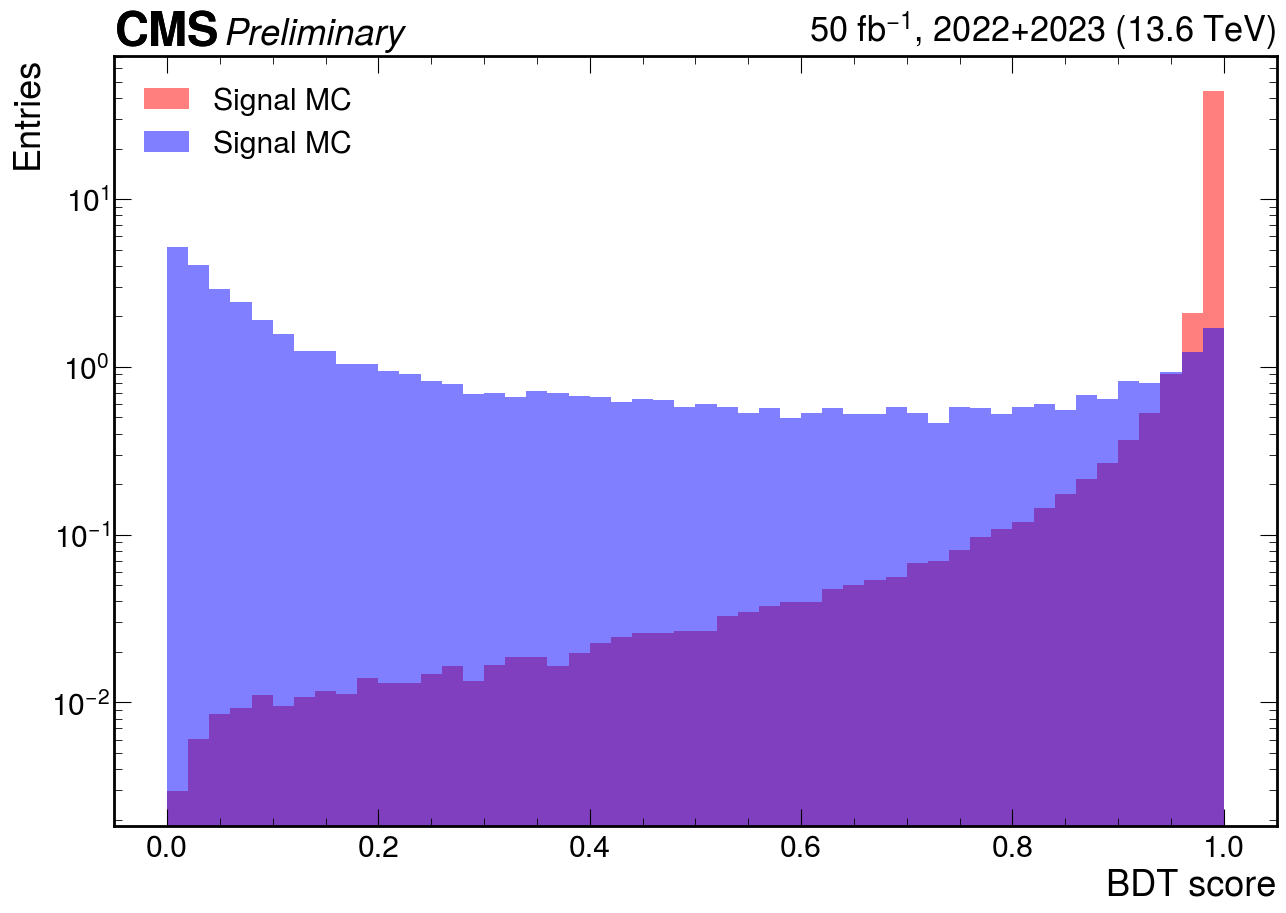

In [201]:
plt.figure(figsize=(15, 10))
plt.yscale('log')
hep.histplot(np.histogram(df[df.eval(signal_sel)]["bdt_cv"].to_numpy(), bins=50, range=(0,1)), density=True, histtype="fill", label="Signal MC", alpha=0.5, color='red');
hep.histplot(np.histogram(df[df.eval(bkg_sel)]["bdt_cv"].to_numpy(), bins=50, range=(0,1)), density=True, histtype="fill", label="Signal MC", alpha=0.5, color='blue');
plt.xlabel("BDT score")
plt.ylabel("Entries")
plt.legend()
hep.cms.text("Preliminary");
hep.cms.label(data=True, year="2022+2023", lumi=50, com=13.6);

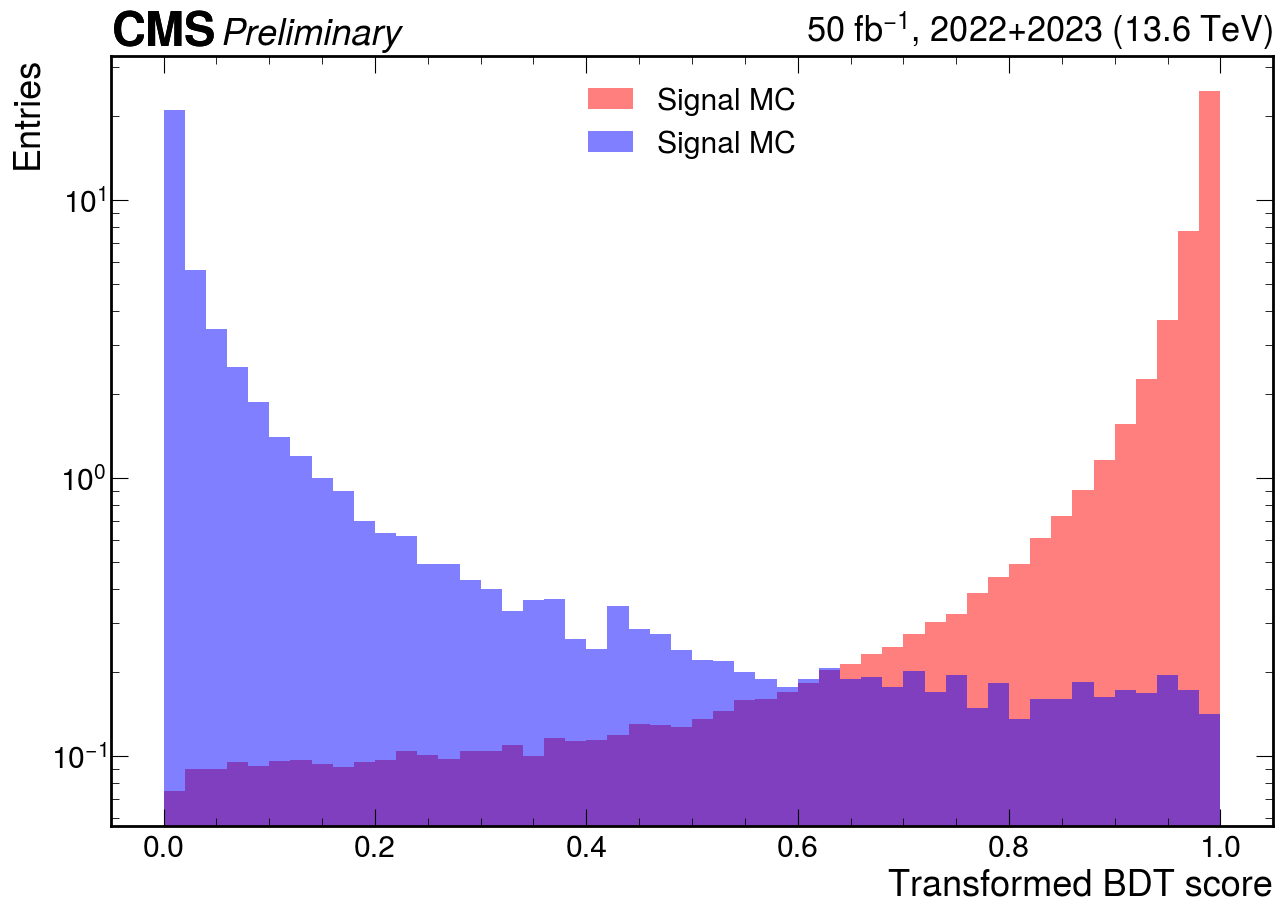

In [202]:
plt.figure(figsize=(15, 10))
plt.yscale('log')
hep.histplot(np.histogram(df[df.eval(signal_sel)]["bdt_cv_2"].to_numpy(), bins=50, range=(0,1)), density=True, histtype="fill", label="Signal MC", alpha=0.5, color='red');
hep.histplot(np.histogram(df[df.eval(bkg_sel)]["bdt_cv_2"].to_numpy(), bins=50, range=(0,1)), density=True, histtype="fill", label="Signal MC", alpha=0.5, color='blue');
plt.xlabel("Transformed BDT score")
plt.ylabel("Entries")
plt.legend()
hep.cms.text("Preliminary");
hep.cms.label(data=True, year="2022+2023", lumi=50, com=13.6);

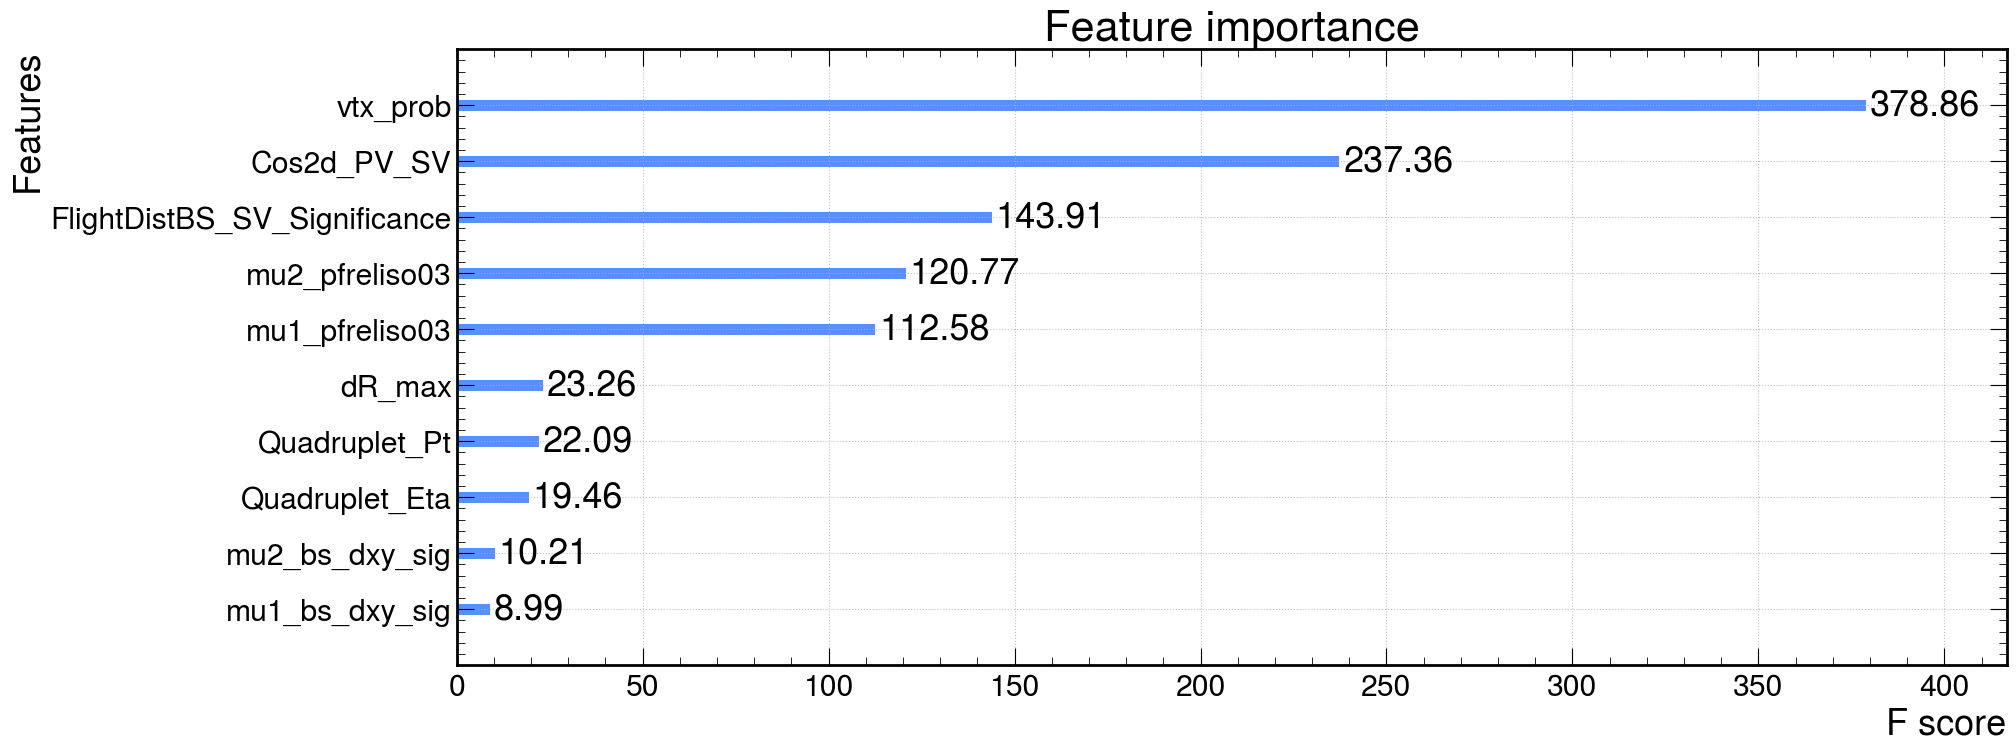

In [203]:
#feature importance
for category_ in xgbcvclassifiers:
    importance = []
    for fold_ in range(kFolds):
        # Get the booster from the xgbmodel
        booster = xgbcvclassifiers[category_][fold_][0].get_booster()
        booster.feature_names = training_variables
    
        # Get the importance dictionary (by gain) from the booster
        importance_temp = booster.get_score(importance_type="gain")
        # make your changes
        for key in importance_temp.keys():
            importance_temp[key] = round(importance_temp[key],2)
        importance.append(importance_temp)

    #average importance across different folds
    importance_avg = importance[0]
    for key in importance_avg.keys():
        importance_avg[key]=0
        for fold_ in range(kFolds):
            importance_avg[key] += importance[fold_][key]/kFolds
        importance_avg[key] = round(importance_avg[key],2)
    
    # provide the importance dictionary to the plotting function
    ax = plot_importance(importance_avg, max_num_features=30, importance_type='gain', show_values=True)

    fig = ax.figure
    fig.set_size_inches(20, 8)
    fig.savefig(out_dir+"/feature_importance_"+category_+".png")